# Ollama X LangChain X Streamlit
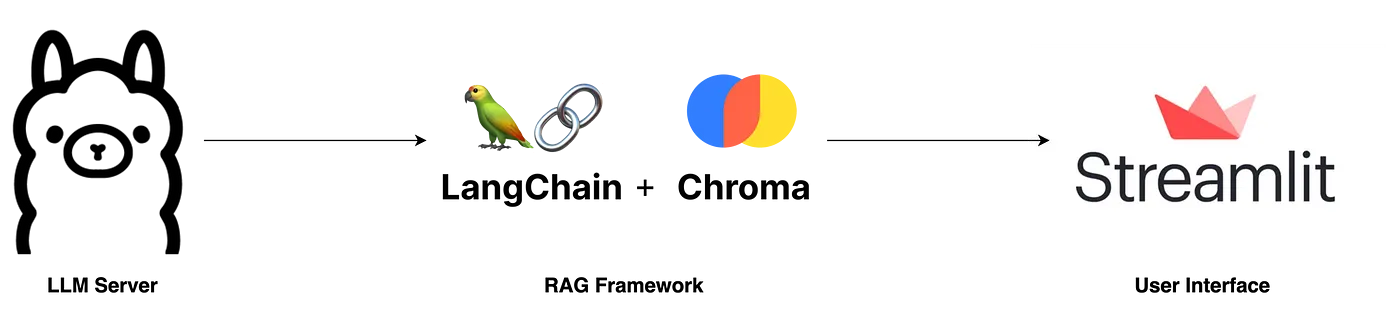

https://medium.com/@vndee.huynh/build-your-own-rag-and-run-it-locally-langchain-ollama-streamlit-181d42805895

In [1]:
%pip install langchain streamlit streamlit_chat chromadb pypdf fastembed

  Using cached langchain-0.1.16-py3-none-any.whl.metadata (13 kB)
  Using cached streamlit-1.33.0-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached streamlit_chat-0.1.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached pypdf-4.2.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached fastembed-0.2.6-py3-none-any.whl.metadata (4.8 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached SQLAlchemy-2.0.29-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached aiohttp-3.9.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.5 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached dataclasses_json-0.6.5-py3-none-any.whl.metadata (25 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_community-0.0.34-py3-none-any.whl.metadata (8.5 kB)
  Using cached langchain_core-0.1.46-py3-none-any.whl.metadata (5.9 kB)
  Using cached langchain_text_splitters-0.0.1-py3-none-any

In [1]:
from langchain_community.vectorstores import Chroma
from langchain_community.chat_models import ChatOllama
from langchain_community.embeddings import FastEmbedEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain.vectorstores.utils import filter_complex_metadata


class ChatPDF:
    vector_store = None
    retriever = None
    chain = None

    def __init__(self):
        self.model = ChatOllama(model="llama3")
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=100)
        self.prompt = PromptTemplate.from_template(
            """
            <s> [INST] Vous êtes un assistant pour les tâches de réponse aux questions. Utilisez les éléments de contexte suivants pour répondre à la question. 
            Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas.. Utilisez trois phrases
             maximum et soyez concis dans votre réponse. [/INST] </s> 
            [INST] Question: {question} 
            Context: {context} 
            Answer: [/INST]
            """
        )

    def ingest(self, pdf_file_path: str):
        docs = PyPDFLoader(file_path=pdf_file_path).load()
        chunks = self.text_splitter.split_documents(docs)
        chunks = filter_complex_metadata(chunks)

        vector_store = Chroma.from_documents(documents=chunks, embedding=FastEmbedEmbeddings())
        self.retriever = vector_store.as_retriever(
            search_type="similarity_score_threshold",
            search_kwargs={
                "k": 3,
                "score_threshold": 0.5,
            },
        )

        self.chain = ({"context": self.retriever, "question": RunnablePassthrough()}
                      | self.prompt
                      | self.model
                      | StrOutputParser())

    def ask(self, query: str):
        if not self.chain:
            return "Please, add a PDF document first."

        return self.chain.invoke(query)

    def clear(self):
        self.vector_store = None
        self.retriever = None
        self.chain = None

In [2]:
import os
import tempfile
import streamlit as st
from streamlit_chat import message
from rag import ChatPDF

st.set_page_config(page_title="ChatPDF")


def display_messages():
    st.subheader("Chat")
    for i, (msg, is_user) in enumerate(st.session_state["messages"]):
        message(msg, is_user=is_user, key=str(i))
    st.session_state["thinking_spinner"] = st.empty()


def process_input():
    if st.session_state["user_input"] and len(st.session_state["user_input"].strip()) > 0:
        user_text = st.session_state["user_input"].strip()
        with st.session_state["thinking_spinner"], st.spinner(f"Thinking"):
            agent_text = st.session_state["assistant"].ask(user_text)

        st.session_state["messages"].append((user_text, True))
        st.session_state["messages"].append((agent_text, False))


def read_and_save_file():
    st.session_state["assistant"].clear()
    st.session_state["messages"] = []
    st.session_state["user_input"] = ""

    for file in st.session_state["file_uploader"]:
        with tempfile.NamedTemporaryFile(delete=False) as tf:
            tf.write(file.getbuffer())
            file_path = tf.name

        with st.session_state["ingestion_spinner"], st.spinner(f"Ingesting {file.name}"):
            st.session_state["assistant"].ingest(file_path)
        os.remove(file_path)


def page():
    if len(st.session_state) == 0:
        st.session_state["messages"] = []
        st.session_state["assistant"] = ChatPDF()

    st.header("ChatPDF")

    st.subheader("Upload a document")
    st.file_uploader(
        "Upload document",
        type=["pdf"],
        key="file_uploader",
        on_change=read_and_save_file,
        label_visibility="collapsed",
        accept_multiple_files=True,
    )

    st.session_state["ingestion_spinner"] = st.empty()

    display_messages()
    st.text_input("Message", key="user_input", on_change=process_input)


if __name__ == "__main__":
    page()

ModuleNotFoundError: No module named 'rag'

### LangChain X Ollama Examples

##### Simple example from LangChain

In [1]:
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama

llm = Ollama(model="llama3")
print(llm.invoke("Tell me a joke"))

Here's one:

Why couldn't the bicycle stand up by itself?

(Wait for it...)

Because it was two-tired!

Hope that made you laugh! Do you want to hear another?


##### Prompt injection

In [8]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters
llm = ChatOllama(model="llama3")
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# /docs/expression_language/why
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for
# production
print(chain.invoke({"topic": "Space travel"}))
print("-------")
print(chain.invoke({"topic": "Dogs"}))

Why did the astronaut break up with his girlfriend before going to Mars?

Because he needed space!
-------
Why did the dog go to the vet?

Because he was feeling ruff!

Hope that made you howl with laughter!
